<h1><center>ResNet-50识别岩石样本</center></h1>

In [1]:
# 导包
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras import backend
from numba import cuda
from keras.models import load_model
from keras import models,layers 
from keras.applications.vgg16 import preprocess_input,decode_predictions
from PIL import Image
%matplotlib inline 

Using TensorFlow backend.


## 模型搭建

In [2]:
# 引入ResNet网络

num_classes = 7  # rock(sample)为7类
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

model = ResNet50Model()
print("num_layers = ", len(model.layers))

C:\Users\yyqx\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


num_layers =  177


In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [4]:
# 冻结前168层，但不冻结其间的Batch Normalization
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True

    if isinstance(layer, K.layers.BatchNormalization):
        layer.momentum = 0.9    # 认为动量为0.9时能更好的适应新的数据集

for layer in model.layers[:num_feerezed_layer]:

    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False

# 检查可训练层冻结是否正确
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  False
conv1_pad   trainable =  False
conv1   trainable =  False
bn_conv1   trainable =  True
activation_1   trainable =  False
pool1_pad   trainable =  False
max_pooling2d_1   trainable =  False
res2a_branch2a   trainable =  False
bn2a_branch2a   trainable =  True
activation_2   trainable =  False
res2a_branch2b   trainable =  False
bn2a_branch2b   trainable =  True
activation_3   trainable =  False
res2a_branch2c   trainable =  False
res2a_branch1   trainable =  False
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  False
activation_4   trainable =  False
res2b_branch2a   trainable =  False
bn2b_branch2a   trainable =  True
activation_5   trainable =  False
res2b_branch2b   trainable =  False
bn2b_branch2b   trainable =  True
activation_6   trainable =  False
res2b_branch2c   trainable =  False
bn2b_branch2c   trainable =  True
add_2   trainable =  False
activation_7   trainable =  False
res2c_branch2a   trainable =  False


## 模型训练

In [5]:
# 载入训练数据
rock_path = './train_1(sample)'
label_path = './label_new(sample).csv'
label = pd.read_csv(label_path)


img_pathes = ['{}-1.bmp'.format(i) if i<=320 else '{}-1.jpg'.format(i) for i in label['样本编号']  ]
img_pathes = [os.path.join(rock_path,i) for i in img_pathes]# 补全路径,全部图片的路径
label = label['类别标签']
label = list(label)

In [6]:
# 分割训练集和测试集
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(img_pathes, label, test_size=val_ratio, 
                                                  random_state=42, shuffle=True, stratify=label)

In [7]:
# 归一化，并且把输入的图片从RGB模式改为BGR模式
def imgsub(img):
    img_res = np.zeros(img.shape)          # R G B
    img_res[:,:,0] = img[:,:,2]            # B = B - B
    img_res[:,:,1] = img[:,:,1]            # G = G - G
    img_res[:,:,2] = img[:,:,0]            # R = R - R
    return img_res  # B G R

In [8]:
# 定义生成器，用于训练时batch的生成（小批量生成可以避免内存不够）
def Generator(img_set,labels,batch_size):
    while True:
        img_batch = []
        label_batch = []
        for i in range(len(img_set)):
            img_path = img_set[i]
            img = Image.open(img_path)
            img = img.convert('RGB')
            img = img.resize((224,224))
            img = np.asarray(img)
            img = imgsub(img)
            img_batch.append(img)

            label = labels[i]
            label_batch.append(label)
            if (i+1)%batch_size==0 or (i+1) == len(img_set):# 凑够batch_size张图片的矩阵
                img_batch = np.array(img_batch) # 拼成一个大矩阵，用于训练
                label_batch = np.array(label_batch)
                label_batch = K.utils.to_categorical(label_batch, num_classes=7)
                yield img_batch,label_batch

                img_batch = []
                label_batch = []

In [9]:
if os.path.exists('Best_rock_Model(ResNet).h5'):
    model_Best = 'Best_rock_Model(ResNet).h5'
    model = load_model(model_Best)
else:
    model = ResNet50Model()

    
# 断点续训
checkpoint = ModelCheckpoint('Best_rock_Model(ResNet).h5', verbose=1, monitor='val_accuracy', 
                             save_best_only=True, mode='max')

# 指定模型的损失函数，优化器，衡量指标
model.compile(loss='categorical_crossentropy', optimizer=K.optimizers.Adamax(lr=1e-4),
              metrics=['accuracy'])

# 模型训练
batch_size = 5
model.fit(Generator(x_train, y_train, batch_size),
          steps_per_epoch=len(x_train)//batch_size,
          epochs=20,
          validation_data=Generator(x_val, y_val, batch_size),
          validation_steps=len(x_val) // batch_size,
          callbacks=[checkpoint])

Epoch 1/20
11/11 [==============================] - 62s 6s/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 1.1926 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to Best_rock_Model(ResNet).h5
Epoch 2/20
11/11 [==============================] - 38s 3s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.0050 - val_accuracy: 0.4444

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/20
11/11 [==============================] - 41s 4s/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 1.6792 - val_accuracy: 0.4444

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/20
11/11 [==============================] - 41s 4s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8778 - val_accuracy: 0.6000

Epoch 00004: val_accuracy improved from 0.50000 to 0.60000, saving model to Best_rock_Model(ResNet).h5
Epoch 5/20
11/11 [==============================] - 40s 4s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.8513 - val_

## 模型预测

In [10]:
# 载入图片,进行预测
r = './rock(sample)/1-1.bmp'
img = Image.open(r)
img = img.resize((224,224))
img = np.array(img)
img = img[:,:,:3]
img = imgsub(img)
img = np.expand_dims(img,axis = 0 )


if os.path.exists('Best_rock_Model(ResNet).h5'):
    model_Best = 'Best_rock_Model(ResNet).h5'
    model = load_model(model_Best)

res = model.predict(img)

# 预测结果
print('Results are',res)

Results are [[0.01383554 0.794306   0.09419486 0.02729754 0.01446044 0.01178078
  0.04412495]]


## 预测结果可视化

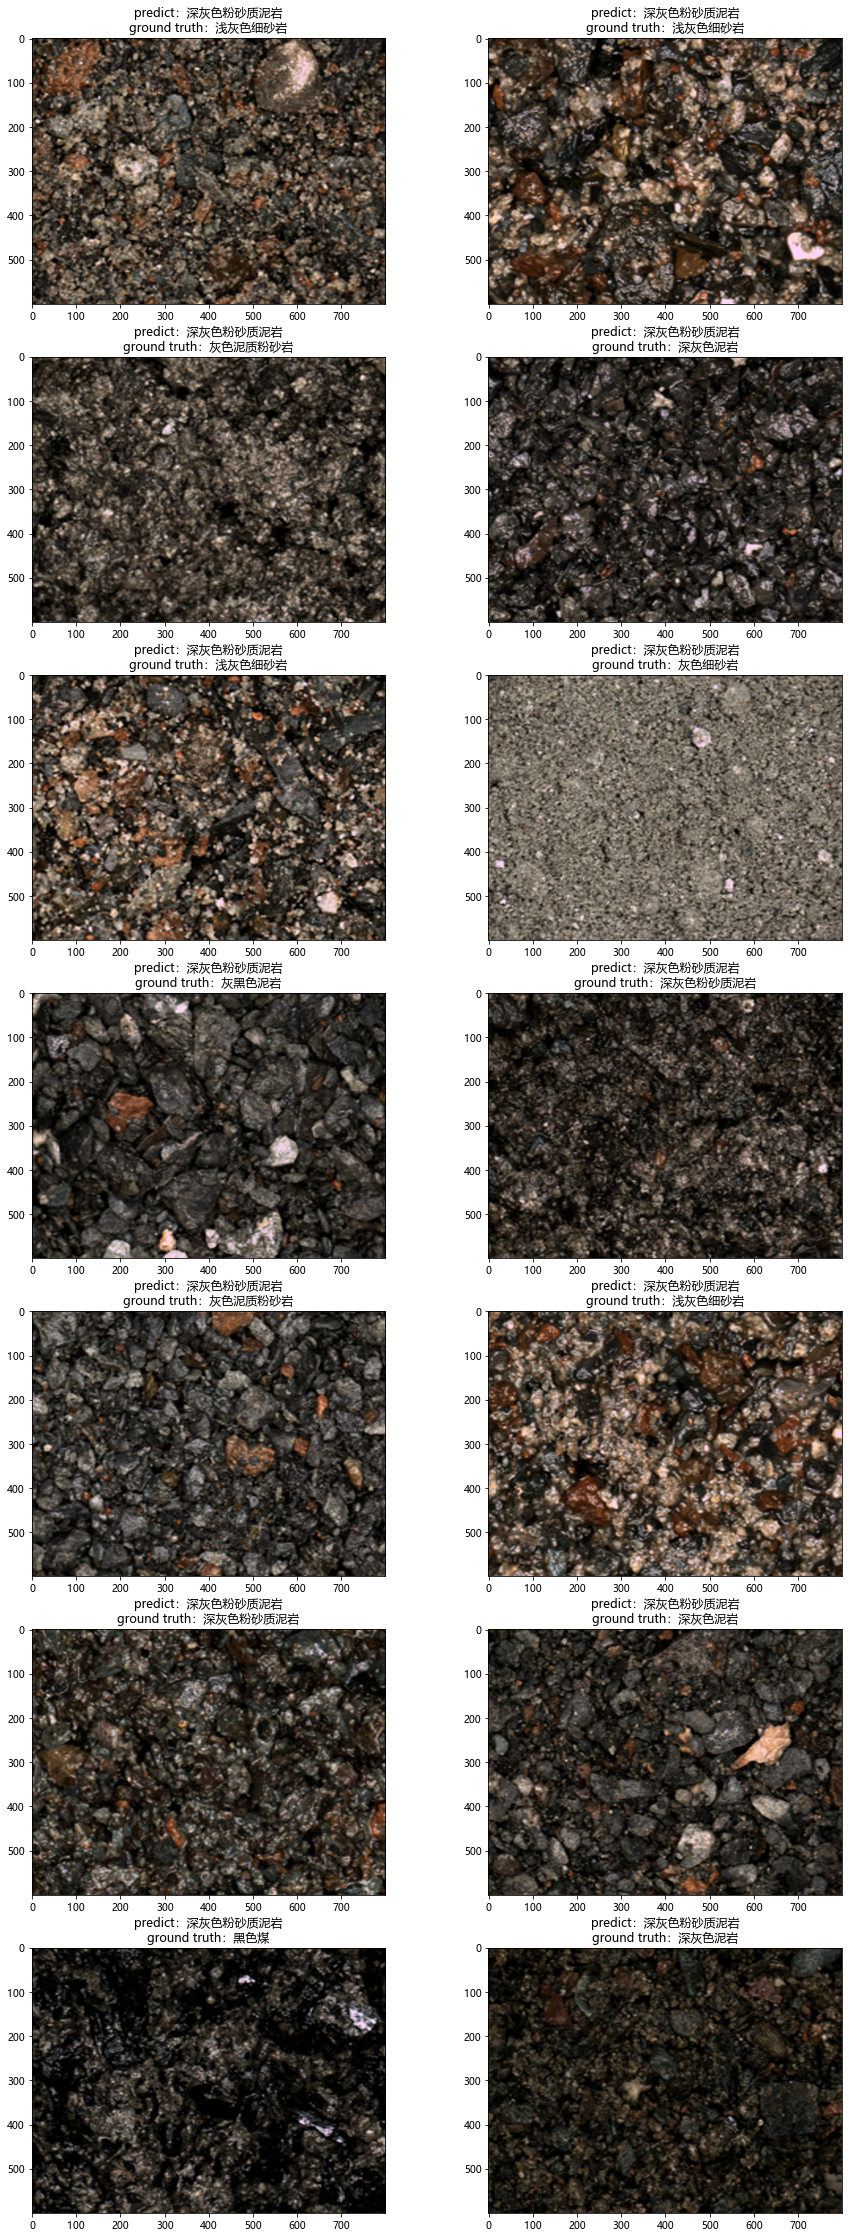

In [11]:
# plt绘图中显示中文和符号
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

df_label = pd.read_csv('label_new(sample).csv')

fig = plt.figure(figsize = (15,40))
for i in range(len(x_val)):
    img_show_name = x_val[i]
    img_show_num = os.path.split(img_show_name)[-1].split('-')[0]
    img_show_num = int(img_show_num)
    
    # 利用样本编号（文件名,x_val）与样本类别的对应关系
    label_show_chinese = df_label['样本类别'][df_label['样本编号']==img_show_num]
    label_show_chinese = label_show_chinese.iloc[0]
    
    img = Image.open(img_show_name).convert('RGB')
    img = img.resize((224,224))
    img = np.array(img)
    img_plot = img.copy()
    
    img = imgsub(img)
    img = np.expand_dims(img,axis = 0 )
    predict = model.predict(img)
    predict_num = np.argmax(res)
    predict_chinese = df_label['样本类别'][df_label['类别标签']==predict_num].iloc[0]# 得到预测结果的中文
    
    ax = fig.add_subplot(7,2,i+1)
    img_plot = Image.fromarray(img_plot).resize((800,600))
    img_plot = np.array(img_plot)
    plt.imshow(img_plot)
    plt.title(f'predict：{predict_chinese}\nground truth：{label_show_chinese}')
     